<a href="https://colab.research.google.com/github/human-centered-ai-lab/kdy-kandinsky-pattern-generator/blob/master/generate_kandinsky_patterns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kandinsky Patterns 

A **Kandinsky Pattern** is of a set of Kandinsky Figures following a "Model of Truth", i.e. for each  Kandinsky Figure, we can tell if it belongs to the Kandinsky Pattern and why this is the case.

A **Kandinsky Figure** consists of 1 ... n shapes in a square with the following assumptions:

*  each shape has a 
  *   type: *circle*, *square*,  *triangle*, etc. 
  *   colour: *red*, *blue*,  *yellow*, etc. 
  *   specifc size and position  
*   Shapes are non overlapping
*   Shapes are completly within the square, i.e. they have a maximal size
*   Shapes are recognisable, i.e. they have a minimal size


### TODOs

* generate descriptions of Kandinsky Figures
* train a caption network, see https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/22_Image_Captioning.ipynb

In [0]:
import numpy as np
import os
import math
import random
from PIL import Image, ImageFont, ImageDraw, ImageEnhance, ImageChops

WIDTH   = 120
MINSIZE = 20
MAXSIZE = 40

kandinsky_colors = ['red','yellow', 'blue']
kandinsky_numbers = ['zero', 'one','two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten']


def square (d,cx,cy,s,f):
  s = 0.7 * s
  d.rectangle(((cx-s/2, cy-s/2), (cx+s/2, cy+s/2)), fill=f)

def circle (d,cx,cy,s,f):
  # correct the size to  the same area as an square
  s = 0.7 * s * 4 / math.pi 
  d.ellipse(((cx-s/2, cy-s/2), (cx+s/2, cy+s/2)), fill=f)

def triangle (d,cx,cy,s,f):
  r = math.radians(30)
  # correct the size to  the same area as an square
  s = 0.7 * s * 3 * math.sqrt(3) / 4
  dx = s * math.cos (r) / 2
  dy = s * math.sin (r) / 2
  d.polygon([(cx,cy-s/2), (cx+dx, cy+dy), (cx-dx,cy+dy)], fill = f)

kandinsky_shapes = [square, circle, triangle]

def kandinskyFigure (shapes, subsampling = 1):
  image = Image.new("RGBA", (subsampling*WIDTH,subsampling*WIDTH), (220,220,220,255))
  d = ImageDraw.Draw(image)
  for s in shapes:
      s['shape']( d, subsampling*s['cx'], subsampling*s['cy'], subsampling*s['size'], s['color'] )
  if subsampling>1:
    image.thumbnail( (WIDTH,WIDTH), Image.ANTIALIAS)
  return image

def overlaps (shapes):
  image = Image.new("L", (WIDTH,WIDTH), 0)
  sumarray = np.array(image)
  d = ImageDraw.Draw(image)
  
  for s in shapes:
    image      = Image.new("L", (WIDTH,WIDTH), 0)
    d = ImageDraw.Draw(image)
    s['shape']( d, s['cx'], s['cy'], s['size'], 10 )
    sumarray = sumarray + np.array(image)

  sumimage = Image.fromarray (sumarray)
  return sumimage.getextrema ()[1] > 10

def combineFigures (n, f):
  images = []
  for i in range (n):
    shapes = f()
    while overlaps (shapes):
      shapes = f()
    image = kandinskyFigure (shapes,4)    
    images.append (image)
  
  allimages = Image.new("RGBA", (WIDTH*n+20*(n-1),WIDTH), (255,255,255,255))
  for i in range (n):
    allimages.paste ( images[i], ( WIDTH*i+20*(i), 0))
  return allimages

A *Generator Function* produces a  Kandinsky Figure , wich belongs to a specific Kandinsky Pattern 

In [0]:
def randomShapes(min, max):
  nshapes  = random.randint (min,max)
  shapes = []
  for i in range (nshapes):
    cx = random.randint (MAXSIZE/2,WIDTH-MAXSIZE/2)
    cy = random.randint (MAXSIZE/2,WIDTH-MAXSIZE/2)
    size  = random.randint (MINSIZE,MAXSIZE)
    col  = random.randint (0,2)
    sha  = random.randint (0,2)
    shape = {'shape':kandinsky_shapes[sha], 'cx':cx, 'cy':cy, 'size':size, 'color':kandinsky_colors[col]}
    shapes.append (shape)
  return shapes

def onlyCircles (min, max):
  nshapes  = random.randint (min,max)
  shapes = []
  for i in range (nshapes):
    cx = random.randint (MAXSIZE/2,WIDTH-MAXSIZE/2)
    cy = random.randint (MAXSIZE/2,WIDTH-MAXSIZE/2)
    size  = random.randint (MINSIZE,MAXSIZE)
    col  = random.randint (0,2)   
    shape = {'shape':circle, 'cx':cx, 'cy':cy, 'size':size, 'color':kandinsky_colors[col]}
    shapes.append (shape)
  return shapes

def shapesOnLine (min, max):
  nshapes  = random.randint (min,max)
  
  dx =  math.cos (random.random()* math.pi * 2) * (WIDTH/2-MAXSIZE/2)
  dy =  math.sin (random.random()* math.pi * 2) * (WIDTH/2-MAXSIZE/2)
  sx = WIDTH/2  - dx  
  sy = WIDTH/2  + dy  
  ex = WIDTH/2  + dx  
  ey = WIDTH/2  - dy  
  dx =  ex-sx
  dy =  ey-sy
  shapes = []
  for i in range (nshapes):
    r = random.random() 
    cx = sx + r * dx
    cy = sy + r * dy
    size  = random.randint (MINSIZE,MAXSIZE)
    col  = random.randint (0,2)
    sha  = random.randint (0,2)
    shape = {'shape':kandinsky_shapes[sha], 'cx':cx, 'cy':cy, 'size':size, 'color':kandinsky_colors[col]}
    shapes.append (shape)

  return shapes

def shapesWithEqualArea(min, max):
  nshapes  = random.randint (min,max)
  shapes = []
  size  = random.randint (MINSIZE,MAXSIZE)
  for i in range (nshapes):
    cx = random.randint (MAXSIZE/2,WIDTH-MAXSIZE/2)
    cy = random.randint (MAXSIZE/2,WIDTH-MAXSIZE/2)
    col  = random.randint (0,2)
    sha  = random.randint (0,2)
    shape = {'shape':kandinsky_shapes[sha], 'cx':cx, 'cy':cy, 'size':size, 'color':kandinsky_colors[col]}
    shapes.append (shape)
  return shapes

def twoPairsOnlyOneWithSameColor():
  shapes = []
  size  = random.randint (MINSIZE,MAXSIZE)

  sha  = random.randint (0,2)
  col  = random.randint (0,2)
  cx = random.randint (MAXSIZE/2,WIDTH-MAXSIZE/2)
  cy = random.randint (MAXSIZE/2,WIDTH-MAXSIZE/2)
  shape = {'shape':kandinsky_shapes[sha], 'cx':cx, 'cy':cy, 'size':size, 'color':kandinsky_colors[col]}
  shapes.append (shape)
 
  colOld =  col 
  while col == colOld:
    col  = random.randint (0,2) 
  cx = random.randint (MAXSIZE/2,WIDTH-MAXSIZE/2)
  cy = random.randint (MAXSIZE/2,WIDTH-MAXSIZE/2)
  size  = random.randint (MINSIZE,MAXSIZE)
  shape = {'shape':kandinsky_shapes[sha], 'cx':cx, 'cy':cy, 'size':size, 'color':kandinsky_colors[col]}
  shapes.append (shape)
  
  shaOld =  sha 
  while sha == shaOld:
     sha  = random.randint (0,2)
      
  col  = random.randint (0,2)
  for i in range (2):
    cx = random.randint (MAXSIZE/2,WIDTH-MAXSIZE/2)
    cy = random.randint (MAXSIZE/2,WIDTH-MAXSIZE/2)
    size  = random.randint (MINSIZE,MAXSIZE)
    shape = {'shape':kandinsky_shapes[sha], 'cx':cx, 'cy':cy, 'size':size, 'color':kandinsky_colors[col]}
    shapes.append (shape)    
  return shapes

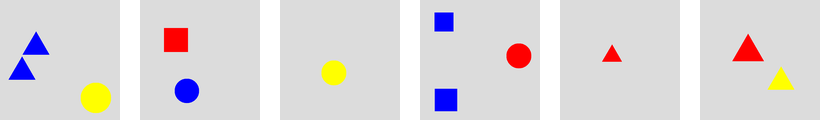

In [0]:
combineFigures (6, lambda: randomShapes(1,3))


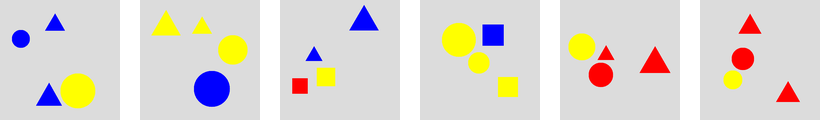

In [0]:
combineFigures (6, lambda: twoPairsOnlyOneWithSameColor())


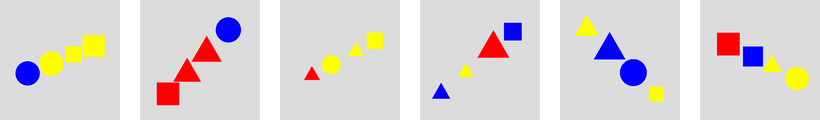

In [0]:
combineFigures (6, lambda: shapesOnLine(4,4))

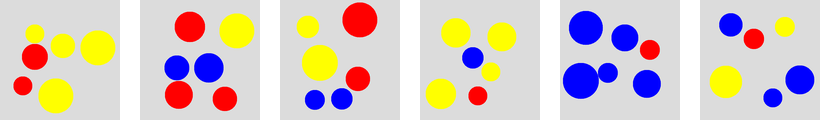

In [0]:
combineFigures (6, lambda: onlyCircles(6,6))

In [0]:
DELTASIZE = MAXSIZE - MINSIZE
SMALLSIZECHECK = MINSIZE + DELTASIZE /3
BIGSIZECHECK   = MAXSIZE - DELTASIZE /3


def descColorShapeSize (shapes, prefix = ''):
    descrition = prefix
    multipleshape = False
    for s in shapes:
        if multipleshape: descrition = descrition + " and " + prefix 
        sizestring = ''
        if s['size'] < SMALLSIZECHECK: sizestring = 'small'
        if s['size'] > BIGSIZECHECK:   sizestring = 'big'
        if len (sizestring) > 0:  descrition = descrition + sizestring +  " "
        descrition = descrition  +  s['color'] +  " " +  s['shape'].__name__
        multipleshape = True 
    return descrition
  
def descNumbers (shapes):  
  descrition =  descColorShapeSize (shapes, 'one ')
  #lets look if we find some patterns
  ns = {}
  nc = {}
  for s in kandinsky_shapes: ns[s] = 0
  for s in kandinsky_colors: nc[s] = 0
  for s in shapes:
      ns[s['shape']] += 1
      nc[s['color']] += 1
  maxcolor = ''
  maxshape = ''
  maxnumcolor = 0
  maxnumshap  = 0
  for c in kandinsky_colors: 
      if nc[c] > maxnumcolor:
        maxnumcolor = nc[c]
        maxcolor = c
  for s in kandinsky_shapes: 
      if ns[s] > maxnumshap:
        maxnumshap = ns[s]
        maxshape = s.__name__

  if maxnumcolor > 1 or maxnumshap > 1:
    if maxnumcolor >= maxnumshap:
        descrition = kandinsky_numbers[maxnumcolor] + " " + maxcolor + " shapes"
    else:  
        descrition = kandinsky_numbers[maxnumshap] + " " + maxshape + "s"
  
    if (maxnumcolor == maxnumshap) and (maxnumcolor == len(shapes)):
        descrition = kandinsky_numbers[maxnumshap] + " " + maxcolor + " " + maxshape + "s"
    
  return descrition  
  
def descPairs (shapes):  
  # thats not perfect, it e.g. does not describe two pairs, or a pair, if some other shape has 3 objects
  descrition =  ""
  ns = {}
  for s in kandinsky_shapes: ns[s] = 0
  for s in shapes:
      ns[s['shape']] += 1
  maxshape = ''
  maxnumshap  = 0
  for s in kandinsky_shapes: 
      if ns[s] > maxnumshap:
        maxnumshap = ns[s]
        maxshape = s.__name__
  if maxnumshap ==  2:
     descrition = "a pair of "+ maxshape + "s"    
  return descrition  

In [0]:
f =  lambda: randomShapes(4,6)
os.makedirs("randomcaptions", exist_ok=True)
for i in range (100):
  shapes = f()
  while overlaps (shapes):
    shapes = f()
  
  descrition = descNumbers (shapes)
  image = kandinskyFigure (shapes,4)  
  filename = "randomcaptions/%06d" % i
  image.save (filename+".png")
  text_file = open(filename+".txt", "w")
  text_file.write(descrition)
  text_file.close()  

yellow square and small blue triangle and yellow square and red circle and red triangle and red circle
three red shapes
a pair of squares


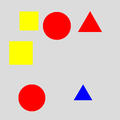

In [0]:
f =  lambda: randomShapes(6,8)
shapes = f()
while overlaps (shapes) or len (descPairs(shapes)) == 0:
    shapes = f()
  
print (descColorShapeSize(shapes))
print ( descNumbers(shapes))
print ( descPairs(shapes))
kandinskyFigure (shapes,4) 
 